- augmentations are done on-the-fly with **set_transform**
- Set __getitem__ return format using this transform. The transform is applied on-the-fly on batches when __getitem__ is called. As set_format(), this can be reset using reset_format().

In [1]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset, Audio, DatasetInfo
from src.data.extraction import CustomFeatureExtractor
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader
import torch_audiomentations
import torch

In [2]:
birdset5k = load_dataset("DBD-research-group/na_metadata5k_ogg_nodecode") 
birdset5k = birdset5k.cast_column(
    column="audio",
    feature=Audio(
        sampling_rate=32_000,
        mono=True,
        decode=True
    )
)

Found cached dataset parquet (/home/lukas/.cache/huggingface/datasets/DBD-research-group___parquet/DBD-research-group--na_metadata5k_ogg_nodecode-de5164d492ad6e9e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
birdset5k_audio = birdset5k.select_columns(['audio', 'primary'])
# also works with set_format
# e.g. ds.set_format(type='numpy', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

In [4]:
birdset5k_audio["train"].format

{'type': None,
 'format_kwargs': {},
 'columns': ['audio', 'primary'],
 'output_all_columns': False}

In [4]:
feature_extractor = CustomFeatureExtractor()

def preprocess_function(samples):
    audio_arrays = [x["array"] for x in samples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        padding=True,
        max_length=32_000*5,
        truncation=True,
        return_tensors="pt"
    )
    return inputs

In [5]:
encoded_birdset = birdset5k_audio.map(
    preprocess_function,
    remove_columns=['audio'],
    batched=True,
    batch_size=500,
    load_from_cache_file=True,
    num_proc=4
)

# num proc speeds up the mapping process significantly
# takes 4 minutes to preprocess and cut to 5 seconds (note that everything hs be loaded in this mapping function )

Loading cached processed dataset at /home/lukas/.cache/huggingface/datasets/DBD-research-group___parquet/DBD-research-group--na_metadata5k_ogg_nodecode-de5164d492ad6e9e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-9c9b1719fce9668d_*_of_00004.arrow
Loading cached processed dataset at /home/lukas/.cache/huggingface/datasets/DBD-research-group___parquet/DBD-research-group--na_metadata5k_ogg_nodecode-de5164d492ad6e9e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-57a6c557954de378_*_of_00004.arrow


In [7]:
encoded_birdset["train"].format

{'type': None,
 'format_kwargs': {},
 'columns': ['primary', 'input_values'],
 'output_all_columns': False}

In [9]:
# very important, otherwise only a list is returned and dataloader does not work
encoded_birdset.set_format("np")

In [10]:
encoded_birdset["train"].format

{'type': 'numpy',
 'format_kwargs': {},
 'columns': ['primary', 'input_values'],
 'output_all_columns': False}

In [10]:
encoded_birdset["train"][0]["input_values"]

array([ 0.00141759,  0.00141759,  0.00141757, ..., -0.22464915,
       -0.22876795, -0.13290943], dtype=float32)

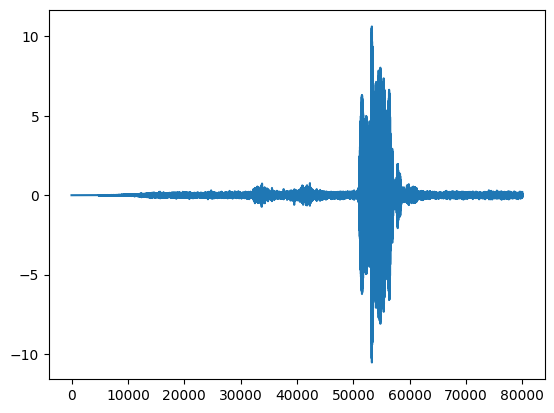

In [11]:
plt.plot(encoded_birdset["train"][50]["input_values"])

In [11]:
dataloader = DataLoader(
    encoded_birdset["train"],
    batch_size=16,
    shuffle=False,
    num_workers=4,
)

In [12]:
for instance in tqdm(encoded_birdset["train"]):
    pass

#<1 second 

  0%|          | 0/4316 [00:00<?, ?it/s]

100%|██████████| 4316/4316 [00:00<00:00, 5622.33it/s]


In [39]:
from torch_audiomentations import Compose, Gain, PolarityInversion, AddColoredNoise
from torchvision.transforms import ToTensor

train_transforms = Compose(
    transforms=[
        Gain(
            min_gain_in_db=-15.0,
            max_gain_in_db=5.0,
            p=0.5,
            output_type="tensor",
        ),
        AddColoredNoise(p=0.5, sample_rate=32_000, output_type="tensor"),
        PolarityInversion(p=0.5, output_type="tensor"),
    ],
    output_type="tensor"
)

In [40]:
def transforms(batch):
    audio = torch.Tensor(batch["input_values"]).unsqueeze(1)
    labels = torch.Tensor(batch["primary"])
    #print(batch["input_values"].shape)
    augmented_audio = [train_transforms(raw_audio).squeeze() for raw_audio in audio.unsqueeze(1)]
    batch["input_values"] = augmented_audio
    batch["labels"] = labels
    return batch

In [16]:
train_ds = encoded_birdset["train"]

In [17]:
train_ds.format

{'type': 'numpy',
 'format_kwargs': {},
 'columns': ['primary', 'input_values'],
 'output_all_columns': False}

In [46]:
# set transform
train_ds.set_transform(transforms, output_all_columns=False)

In [20]:
train_ds.format["format_kwargs"]

{'transform': <function __main__.transforms(batch)>}

In [19]:
train_ds.format

{'type': 'custom',
 'format_kwargs': {'transform': <function __main__.transforms(batch)>},
 'columns': ['primary', 'input_values'],
 'output_all_columns': False}

In [76]:
dataloader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=False,
    num_workers=4,
)

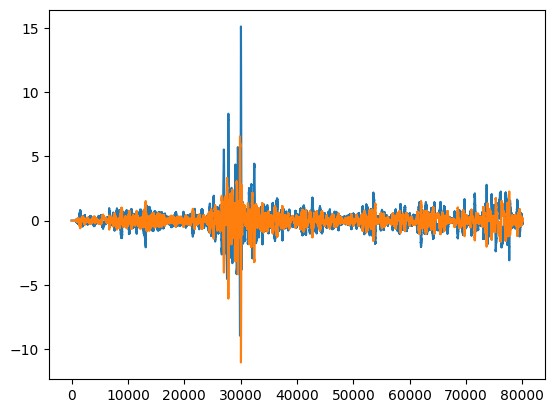

In [34]:
plt.plot(train_ds[0]["input_values"].squeeze())
plt.plot(train_ds[0]["augmented"].squeeze())

In [ ]:
import IPython.display as ipd

In [44]:
ipd.Audio(data=train_ds[10]["input_values"].squeeze(), rate=32000)

In [46]:
ipd.Audio(data=train_ds[10]["augmented"].squeeze(), rate=32000)

In [27]:
train_ds[0]["augmented"].shape

KeyError: 'augmented'

In [28]:
next(iter(dataloader))["input_values"].shape

torch.Size([16, 160000])

In [37]:
next(iter(dataloader))["augmented"].shape

torch.Size([4, 1, 1, 80000])

In [68]:
next(iter(dataloader))

{'primary': tensor([12, 12, 37,  6]),
 'input_values': tensor([[[-1.0800e-03, -1.0800e-03, -1.0800e-03,  ...,  1.7115e-01,
            1.7429e-01,  1.0126e-01]],
 
         [[ 3.7130e-05,  3.7129e-05,  3.7130e-05,  ...,  6.7985e-02,
            4.2436e-02, -1.6151e-02]],
 
         [[-2.8425e-03, -2.8425e-03, -2.8425e-03,  ...,  3.5031e-01,
            9.4016e-01,  8.4158e-01]],
 
         [[-3.4621e-05, -2.8741e-05, -3.9528e-05,  ...,  8.5582e-01,
           -4.2872e-01, -8.2067e-01]]]),
 'labels': tensor([12., 12., 37.,  6.])}

In [42]:
dataloader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=False,
    num_workers=4,
)

In [43]:
for batch in tqdm(dataloader):
    pass

# takes ~40-50 seconds with 2 p=0.5 augmentations

  0%|          | 0/270 [00:00<?, ?it/s]

100%|██████████| 270/270 [00:43<00:00,  6.28it/s]


In [47]:
import IPython.display as ipd
ipd.Audio(data=train_ds[10]["input_values"].squeeze(), rate=32000)

In [49]:
train_ds.set_format("pt")

In [45]:
dataloader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=False,
    num_workers=4,
)
for batch in tqdm(dataloader):
    pass


# takes < 1 second without augmentations

100%|██████████| 270/270 [00:00<00:00, 316.18it/s]


In [50]:
import IPython.display as ipd
ipd.Audio(data=train_ds[10]["input_values"].squeeze(), rate=32000)